# Assignment 4: Seeds

In this assignment, we apply $k$-means ckustering and linear regression on a dataset that contains geometric measurement data on wheat kernels of different species, obtained by x-raying the kernels. The dataset is available at the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/236/seeds).

Each observation has seven features plus a numerical class label that identifies the species of wheat in question. The features are listed in the following table.

Make sure to add the suggested column name to your DataFrame after loading the dataset.

| Column | Feature                           | Suggested column name     |
|--------|-----------------------------------|---------------------------|
|1       | Area $A$                          | `area`                    |
|2       | Perimeter $P$                     | `perimeter`               |
|3       | Compactness $C = \frac{4πA}{P^2}$ | `compactness`             |
|4       | Length of kernel                  | `length`                  |
|5       | Width of kernel                   | `width`                   |
|6       | Asymmetry coefficient             | `asymmetry coefficient`   |
|7       | Length of the kernel groove       | `length of kernel groove` |
|8       | Numerical class label             | `class`                   |

# Clustering

## Question 1

We will start by implementing a simplified version of $k$-means clustering ([Lloyd's algorithm](https://en.wikipedia.org/wiki/K-means_clustering#Standard_algorithm_(naive_k-means))). The class will largely correspond to the interface of [`sklearn.cluster.KMeans`](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html).

Although the class shall be compatible (and yield the same results) as the implementation in sklearn, you are **not** to use sklearn; importing sklearn modules will cause the grading to fail. However, you are encouraged to test and verify that you get the same results (assuming fixed initialization).

The question is split into a number of subquestions. You should write your answer in the same cell for **all** subquestions. The grader just tests different aspects of the same class for each subquestion.

In [ ]:
# Codegrade Tag Question1
# Do *not* remove the tag above
# Implement the class below

import numpy as np

class KMeansManual:
    """
    Implements Lloyd's algorithm for k-means clustering.

    Member variables:
    - n_clusters : int, the parameter k (number of clusters)
    - init : array, optional, initial clusters (or none)
    - n_feature_in_ : int, length of vectors
    - labels_ : array of integers of length n, after fitting, the cluster labels of the dataset
    - cluster_centers_ : array of shape n*d, the fitted cluster centers
    - inertia_ : float, sum of squared euclidean distances from each datapoint to the associated cluster center
    """

    def __init__(self, n_clusters, init = None, random_state = None):
        """
        Constructor, sets the parameters

        Parameters:
        - n_clusters : int, the parameter k (number of clusters)
        - init : array, optional, initial clusters; if None, clusters will be randomly initialized by selecting k random points from the dataset during fit(); otherwise, must be an array of shape k*d and the number of features in the dataset must match d
        - random state : integer, optional, if init is not None, this parameter is ignored; sets the random number seed for selecting the random datapoints
        """
        assert n_clusters > 0
        self.n_clusters = n_clusters
        self.random_state = random_state
        if init is not None:
            assert init.ndim == 2
            assert init.shape[0] == n_clusters
            self.init = init.copy()
        else:
            self.init = None

        # Attributes set by fit()
        self.labels_ = None
        self.cluster_centers_ = None
        self.inertia_ = None
        self.n_features_in_ = None

    def assign_labels(self, X, cluster_centers):
        """
        Given the n*d dataset X, returns an integer array of length n where each element has value 0, 1, ..., k-1, to indicate the index of the closest cluster center (in terms of squared Euclidean distance)

        Parameters:
        - X : array, n*d dataset
        - cluster_centers : array of shape k*d, present cluster centers

        Return value:
        - an integer array of length n where the ith element corresponds to the cluster label of the closest cluster center of that datapoint
        """
        assert isinstance(X,np.ndarray)
        assert isinstance(cluster_centers,np.ndarray)
        assert X.ndim == 2 and cluster_centers.ndim == 2
        assert cluster_centers.shape[0] == self.n_clusters
        assert X.shape[1] == cluster_centers.shape[1]

        # Compute squared distances to all centers: (n, k)
        # Using broadcasting for efficiency.
        diff = X[:, None, :] - cluster_centers[None, :, :]
        dists_sq = np.sum(diff * diff, axis=2)
        labels = np.argmin(dists_sq, axis=1).astype(int)

        return labels

    def compute_cluster_centers(self, X, labels):
        """
        Determine the cluster centroids, that is, the mean of the vectors associated with the same cluster label.

        Parameters:
        - X : array of shape n*d, the dataset
        - labels : 1-dimensional integer array of length n, the present label assignments

        Return value:
        - An array of shape k*d, the current cluster centers
        """
        assert isinstance(X,np.ndarray)
        assert isinstance(labels,np.ndarray)
        assert X.ndim == 2
        assert labels.ndim == 1
        assert X.shape[0] == labels.shape[0]

        k = self.n_clusters
        n, d = X.shape
        centers = np.zeros((k, d), dtype=float)

        # Compute means per cluster
        for c in range(k):
            mask = (labels == c)
            if np.any(mask):
                centers[c] = X[mask].mean(axis=0)
            else:
                # If a cluster is empty, keep the center at zero for now.
                # (fit() will handle this by reusing previous centers.)
                centers[c] = 0.0

        return centers

    def compute_inertia(self, X, labels, cluster_centers):
        """
        Given the n*d dataset, the n-vector of cluster labels, and the k*d array of cluster centers, computes the inertia, that is, the sum of squared Euclidean distances from each datapoint to the closest cluster center (as identified by the cluster label)

        Parameters:
        - X : array of shape n*d, the dataset
        - labels : integer array of length n, the cluster labels of each datapoint
        - cluster_centers : array of shape k*d, the present cluster centers

        Return value:
        - float, the sum of squared euclidean distances to closest cluster centers
        """
        assert isinstance(X,np.ndarray)
        assert isinstance(cluster_centers,np.ndarray)
        assert isinstance(labels,np.ndarray)
        assert X.ndim == 2 and cluster_centers.ndim == 2
        assert labels.ndim == 1
        assert cluster_centers.shape[0] == self.n_clusters
        assert X.shape[0] == labels.shape[0]
        assert X.shape[1] == cluster_centers.shape[1]
        
        assigned_centers = cluster_centers[labels]
        diff = X - assigned_centers
        inertia = float(np.sum(diff * diff))
        return inertia

    def fit(self,X):
        """
        Fit the dataset X, that is, compute the cluster centers and assignments.

        Parameters:
        - X : n*d array of observations; if init was not None, then d must match the second axis of init; otherwise, k random row vectors are picked from X to serve as initial clusters (if random_state was not None, then the same choice should always be made)

        Return value:
        - Returns self
        """
        assert isinstance(X, np.ndarray)
        assert X.ndim == 2
        n, d = X.shape
        self.n_features_in_ = d

        # Initialize centers
        if self.init is not None:
            assert self.init.shape[1] == d, "X must have same number of features as provided initial centers."
            centers = self.init.astype(float, copy=True)
        else:
            rng = np.random.RandomState(self.random_state) if self.random_state is not None else np.random
            assert self.n_clusters <= n, "n_clusters cannot exceed number of samples when using random initialization."
            init_idx = rng.choice(n, size=self.n_clusters, replace=False)
            centers = X[init_idx].astype(float, copy=True)

        # Lloyd's algorithm
        prev_labels = None
        while True:
            labels = self.assign_labels(X, centers)

            # Stop if assignments no longer change
            if prev_labels is not None and np.array_equal(labels, prev_labels):
                break
            prev_labels = labels

            new_centers = self.compute_cluster_centers(X, labels)

            # Handle any empty clusters by keeping the previous center for that cluster
            # (This keeps the algorithm stable without needing extra reinitialization policy.)
            for c in range(self.n_clusters):
                if not np.any(labels == c):
                    new_centers[c] = centers[c]

            centers = new_centers

        # Final attributes
        self.labels_ = labels
        self.cluster_centers_ = centers
        self.inertia_ = self.compute_inertia(X, labels, centers)

        return self

## Question 1a

Implement the method `assign_labels`. The function takes as parameter the dataset in question and the current cluster centers. It then assigns a *cluster label* for each datapoint that corresponds to the closest cluster center, in terms of squared Euclidean distance.

That is, suppose the dataset is the $n\times d$ matrix $X$ (so each row is a datapoint on $d$ features). For $i\in \{1,2,\ldots,n\}$, denote each observation (a row of $X$) by the $d$-vector $x_i$. Suppose the present cluster centers are $m_\ell$ for $\ell\in\{1,2,\ldots,k\}$ (provided as a $k\times d$ matrix). For each $i$, we compute $\arg\min_{\ell\in\{1,2,\ldots,k\}} \sum_{j=1}^d (m_{\ell j}-x_{ij})^2$ as the cluster label for the $i$th observation. Here $m_{\ell j}$ and $x_{i j}$ are the $j$th components of $m_\ell$ and $x_i$, respectively. The return value of the function shall be a vector of length $n$ whose $i$th entry has been thus computed.

## Question 1b

Implement the method `compute_cluster_centers`. The function takes as parameter the dataset in question and the current cluster labels. It then computes the *centroid* of the new clusters as the arithmetic mean of the points associated with the cluster.

For $\ell\in\{1,2,\ldots,k\}$, suppose $C_\ell$ is the set of data point indices that have been mapped to the $\ell$th cluster. Let $x_i$ be the $i$th row of the $n\times d$ data matrix $X$. The new cluster centroid $m_\ell$ is then computed as $m_\ell = \frac{1}{|C_\ell|}\sum_{i\in C_\ell} x_i$. The return value shall be a $k\times d$ array whose rows correspond to the new cluster centroids.

## Question 1c

Implement the method `compute_inertia`. The function takes as parameter the dataset, the current cluster labels, and the current centroids. It then computes the *inertia*: the sum of squared Euclidean distances from each point to its closest centroid as determined by the label.

That is, suppose now that $c_i\in\{1,2,\ldots,k\}$ is the cluster label of the $i$th datapoint ($i$th row of $X$). We want to compute
$\sum_{i=1}^n \sum_{j=1}^d (m_{c_i j} - x_{i j})^2$.

## Question 1d

Using the functions implemented in Question 1a--1c, implement the function `fit` that fits the dataset into the model, using Lloyd's algorithm.

If the initial centroids had been specified in the constructor, the dataset shall have the same number of features as the initial centroids. Otherwise, you shall draw $k$ points at random from the dataset to serve as the initial centroids. If a `random_state` was specified in the constructor, the result shall be deterministic and two repetitions with the same seed shall yield the same result. If initial centroids were specified (that is, not drawn randomly), the result shall correspond to that of `sklearn.cluster.KMeans`.

The function `fit` shall set the following member variables:
- `labels_`
- `cluster_centers_`
- `inertia_`
- `n_features_in_`

The termination condition shall be when inertia does not change (that is, cluster assignments no longer change).

**Hints:**
- When drawing the random initial centroids, make sure you draw the indices **without** replacement, otherwise you might get two identical cluster centroids which causes the algorithm to fail.

## Question 2: Data preprocessing

We will now read the data into a dataframe, normalize the features, and separate the features from the numerical class label. As the features of the dataset contain different units and scales, we will normalize the data by taking the Z-score along each column (except the class label, of course).

Separate the dataset into the dataset `X` that should contain $n$ rows and 7 columns, in the same order as in the data. Apply Z-score normalization to each column. Then separate the class label to an $n$-vector `y`.


Use Pandas to read the data from `seeds.tsv` into a dataframe called `df`. The data lacks column names; use the column names as described at the top of this document.

Then, separate the features of the data from the class label. Store the integer-valued class labels in a vector called `y`. Apply $Z$-score normalization on all vectors and store the normalized features in an $n\times d$ matrix `X`. Both `X` and `y` have to be NumPy `ndarray`s.

**Hints:**
- From this question on, you are again allowed to use scikit-learn.
- The data is in *tab-delimited* format. The `read_table` function is appropriate.
- [`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) is useful for normalization purposes.
- `StandardScaler` uses the biased estimator for variance, which is what the grader also assumes (this affects the choice of the `ddof` parameter when computing estimate for standard deviation if you choose to do this manually).


In [1]:
# Codegrade Tag Question2
# Do *not* remove the tag above

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Column names for the UCI Seeds dataset (7 features + 1 class label)
col_names = [
    "area",
    "perimeter",
    "compactness",
    "length",
    "width",
    "asymmetry coefficient",
    "length of kernel groove",
    "class"
]

# Read the tab-delimited data
df = pd.read_table("seeds.tsv", header=None, names=col_names)

# Separate label (as integer ndarray) and features
y = df["class"].to_numpy(dtype=int)
X_raw = df.drop(columns=["class"]).to_numpy(dtype=float)

# Z-score normalization (biased variance, matching StandardScaler default)
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

## Question 3: Visualizing the classes
Visualizing multidimensional data like this is a challenge. Visualizations seldom work in more than two dimensions, so we need to project the data into a lower number of dimensions.

### Question 3a: Plotting the features against one another

One way to systematically visualize the data is by projecting it to the constituent dimensions.

Plot a scatter plot between each pair of features, coloring the points by the class label. Can we find structure? Can some pair of features tell all point reliably tell all or some classes apart?

Inlcude in the cell below **one** interesting plot. Remember to label the axes, add a title, color the markers (so that we can tell the class labels apart), and include a legend. Store the figure and axis objects as `fig` and `ax`, respectively. Use the normalized data. Store the **names** of the features you found interesting (the column labels) as `interesting_feature1` and `interesting_feature2`.

In the markdown cell below the code cell, explain in a few sentences why you think this pair of features is interesting and what it shows about the structure.

**Hints:**
- Trying to set legend labels with `ax.legend(blah)` **will not work**, you need to call `scatter` once per class and include a `label` parameter.

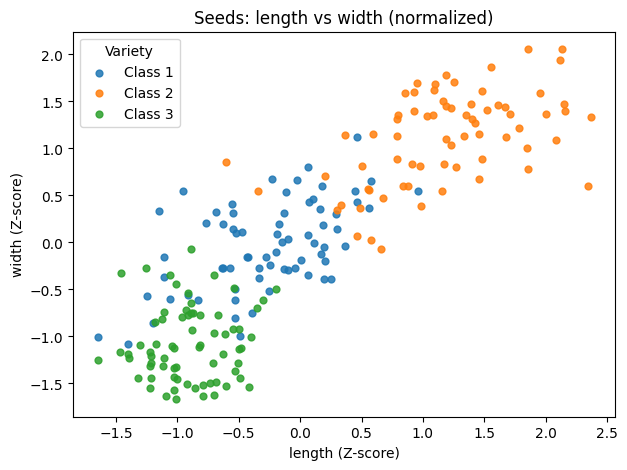

In [2]:
# Codegrade Tag Question3a
# Do *not* remove the tag above

import numpy as np
import matplotlib.pyplot as plt

# Choose an interesting pair of features (names and their indices)
interesting_feature1 = "length"
interesting_feature2 = "width"
i1 = col_names.index(interesting_feature1)
i2 = col_names.index(interesting_feature2)

# Create the scatter plot, one call per class for proper legend entries
fig, ax = plt.subplots(figsize=(7, 5))
for cls in sorted(np.unique(y)):
    mask = (y == cls)
    ax.scatter(
        X[mask, i1-0],  # -0 is a no-op, keeps indexing explicit
        X[mask, i2-0],
        s=24,
        alpha=0.85,
        label=f"Class {cls}"
    )

ax.set_xlabel(interesting_feature1 + " (Z-score)")
ax.set_ylabel(interesting_feature2 + " (Z-score)")
ax.set_title("Seeds: {} vs {} (normalized)".format(interesting_feature1, interesting_feature2))
ax.legend(title="Variety", frameon=True)

plt.show()

*Write your answer here: Why is the pair above interesting?*

The plot shows three fairly compact, mostly non-overlapping groups: one with longer and wider seeds, another with shorter and narrower ones, and the third falling in between. This clear visual structure suggests that even a simple linear boundary in this 2D space could separate much of the data. It is also physically interpretable, since seed length and width capture overall kernel size and shape, which naturally vary across wheat varieties.

### Question 3b: Principal Component Analysis (PCA)

A standard way of projecting data to lower dimensions is by [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis). The method detects orthogonal axes of maximum variance, that is, taking the first few axes should account for the majority of variability in the data.

Apply PCA on `X` and store the two principal explaining the largest fraction of variance (in decreasing order of variance explained) in a $2\times d$ matrix `pca_components`. Store the total fraction of variance explained by the two components in `pca_explained_variance`.

Project the data into two dimensions using the principal components computed above and store the projected data as `X_pca`.

Then, plot the projected-down data as a scatter plot like in Question 3a, colorizing the markers by their class label. Store the axis as `ax_pca`, and, as before, remember to label axes and set  a title and add a legend.

Finally, discuss in a few sentences what the plot looks like. What does it tell us about the structure of the data?

**Hints:**
- `sklearn.decomposition.PCA` can do the transform for you.

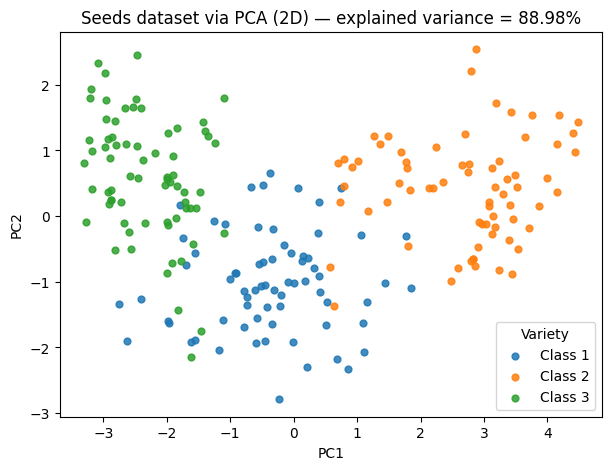

In [3]:
# Codegrade Tag Question3b
# Do *not* remove the tag above

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA: keep two components (in decreasing order of explained variance)
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X)
pca_components = pca.components_    # shape (2, d)
pca_explained_variance = float(pca.explained_variance_ratio_.sum())

# Plot the 2D projection
fig_pca, ax_pca = plt.subplots(figsize=(7, 5))
for cls in sorted(np.unique(y)):
    mask = (y == cls)
    ax_pca.scatter(X_pca[mask, 0], X_pca[mask, 1], s=24, alpha=0.85, label=f"Class {cls}")

ax_pca.set_xlabel("PC1")
ax_pca.set_ylabel("PC2")
ax_pca.set_title(f"Seeds dataset via PCA (2D) — explained variance = {pca_explained_variance:.2%}")
ax_pca.legend(title="Variety", frameon=True)
plt.show()


*Write your explanation in this cell*

The PCA scatter plot shows a clear separation among the three seed classes, with PC1 and PC2 explaining 88.98% of the total variance. Class 2 forms a distinct cluster on the right, Class 1 appears toward the center and bottom, and Class 3 lies mostly on the left. The points form compact, roughly elliptical groups with clear separation along the first principal axis and only minor overlap between two classes along the second. Since the first two components preserve much of the variation in kernel measurements, the 2D plot reflects the essential size and shape differences across varieties and suggests that even simple linear models could separate the data effectively.

### Question 3c: Gaussian random projection

Another way to obtain more feasible visualizations is through random dimensionality reduction. Apply [Gaussian random projection](https://en.wikipedia.org/wiki/Random_projection#Gaussian_random_projection) using `sklearn.random_projection.GaussianRandomProjection` with the following fixed seed (`random_state`): 0. Store the projected data as a $n\times 2$ matrix `X_gauss`.

Store the axis in `ax_gauss`. As before, include a legend and a title. Axes need not be labeled as they do not have a humanly meaningful interpretation.

Again, provide a discussion of a few sentences about what the figure shows about the structure of the data.

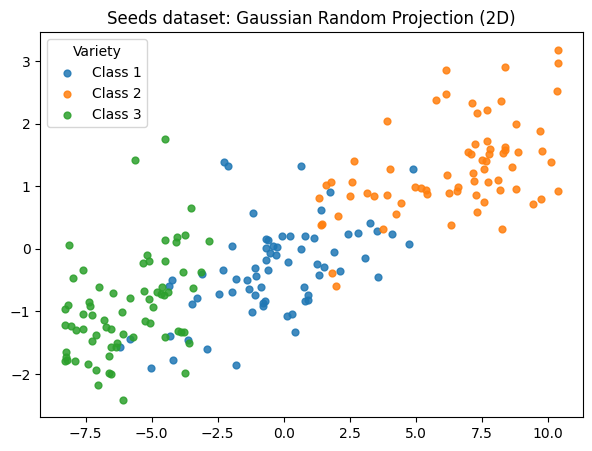

In [4]:
# Codegrade Tag Question3c
# Do *not* remove the tag above

import numpy as np
import matplotlib.pyplot as plt
from sklearn.random_projection import GaussianRandomProjection

# Gaussian Random Projection (2D) with fixed seed
grp = GaussianRandomProjection(n_components=2, random_state=0)
X_gauss = grp.fit_transform(X)   # shape (n, 2)

# Plot, color by class (axes intentionally unlabeled)
fig_gauss, ax_gauss = plt.subplots(figsize=(7, 5))
for cls in sorted(np.unique(y)):
    m = (y == cls)
    ax_gauss.scatter(X_gauss[m, 0], X_gauss[m, 1], s=24, alpha=0.85, label=f"Class {cls}")

ax_gauss.set_title("Seeds dataset: Gaussian Random Projection (2D)")
ax_gauss.legend(title="Variety", frameon=True)
plt.show()

*Write your explanation in this cell.*

The plot also shows three groupings corresponding to the classes, generally arranged from left to right. Compared to the PCA plot, there is more overlap, especially between Class 1 (blue) and Class 2 (orange), so the boundaries are less distinct. Since 2D Gaussian random projection preserves distances only approximately, the axes carry no physical meaning, and separation appears noisier than in PCA. Even so, the groups remain compact, roughly elliptical, and similarly spaced to the PCA view, suggesting that the class structure is robust to linear projections.

## Question 4: Number of clusters
From now on, we'll use the PCA-projected data `X_pca` for all further questions. Let us ignore the class labels for now.

Use `sklearn.cluster.KMeans` to perform $k$-means clustering to the data for $k=1,2,\ldots,30$, and plot the **inertia**, that is, suppose $C_\ell\subseteq\{1,2,\ldots,n\}$ is the set of vectors associated with the cluster $\ell$ (where $\ell\in\{1,2,\ldots,k\}$, $x_i$ is the $i$th vector (where $i\in\{1,2,\ldots,n\}$, and $m_\ell$ is the $\ell$th cluster center, inertia is then the sum of squared distances to the closest cluster center $\sum_{\ell=1}^k \sum_{i\in C_\ell} || x_i - m_\ell ||^2$. Use $1234+k$ as the random seed. Store the inertias as a vector called `inertias` such that `inertias[i]` is the inertia for $k=i+1$.

Then, plot the inertia as a function of $k$. Store the axis as `ax_kclusters`. Remember to label the axes.

Based on your plot, what would be a justifiable choice for the number of clusters? Why? Write a couple of sentences in the cell below the code cell.

**Hints:**
- The inertia can be read directly from the fitted object as the member `inertia_`.

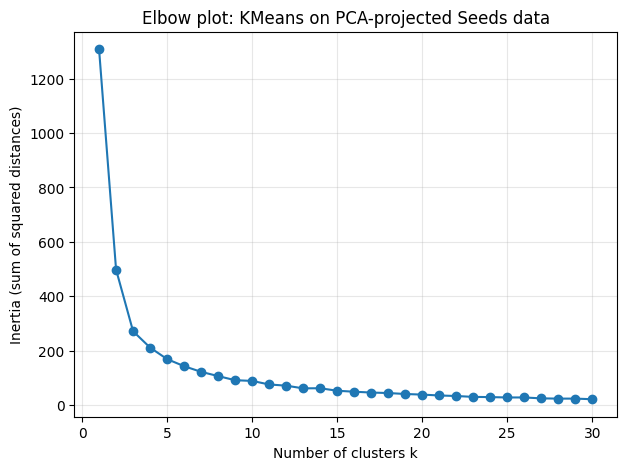

In [ ]:
# Codegrade Tag Question4
# Do *not* remove the tag above

# KMeans on PCA-projected data (k = 1..30) and inertia plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# --- Recompute X_pca to be self-contained ---
col_names = [
    "area",
    "perimeter",
    "compactness",
    "length",
    "width",
    "asymmetry coefficient",
    "length of kernel groove",
    "class",
]
df = pd.read_table("seeds.tsv", header=None, names=col_names)
X = StandardScaler().fit_transform(df.drop(columns=["class"]).to_numpy(dtype=float))
X_pca = PCA(n_components=2, random_state=0).fit_transform(X)

# --- KMeans for k = 1..30, inertia tracking ---
max_k = 30
inertias = []
for k in range(1, max_k + 1):
    km = KMeans(n_clusters=k, random_state=1234 + k)
    km.fit(X_pca)
    inertias.append(km.inertia_)

# Convert to a NumPy array as requested
inertias = np.array(inertias)

# --- Plot inertia vs k ---
fig_k, ax_kclusters = plt.subplots(figsize=(7, 5))
ax_kclusters.plot(range(1, max_k + 1), inertias, marker="o")
ax_kclusters.set_xlabel("Number of clusters k")
ax_kclusters.set_ylabel("Inertia (sum of squared distances)")
ax_kclusters.set_title("Elbow plot: KMeans on PCA-projected Seeds data")
ax_kclusters.grid(True, alpha=0.3)

plt.show()

*Write your answer here*

A justifiable choice for the number of clusters is 3. The curve drops steeply from k=1 to k=3 and then flattens, so additional clusters yield only marginal inertia reduction—classic “elbow” at k=3. This also aligns with the known three wheat varieties, suggesting three well-separated groups in the PCA space.

## Question 5: Rand index

Apply $k$-means clustering to the data, but choose $k$ to match the number of underlying species of wheat. It would seem like a reasonable assumption that there should be an equal number of clusters to the number of interesting classes in the data. Use the random seed 112233. Store your cluster labels as `labels`.

Compute the Rand index of the clustering you obtain. The Rand index looks at each pair of points, and reports the fraction of points that are either in the same cluster in both clusterings, or in different clusters in both clusterings. That is, suppose $c_i$ is the cluster label of point $i$ in one clustering and $c'_i$ in another. The Iverson bracket notation is defined as follows:
$[P]=1$ if $P$ is true, and $[P]=0$ otherwise. Using the Iverson bracket notation, the Rand index $R$ could be thus defined as
$\frac{1}{n \choose 2}\sum_{i=1}^{n-1}\sum_{j=i+1}^n [c_i=c_j\wedge c'_i=c'_j]+[c_i\neq c_j\wedge c'_i\neq c'_j]$. Store it as `rand_index`.

Compute the Rand index between the clustering you obtained using $k$-means and the assumed correct clustering based on class labels.

**Hints:**
- Rand index can be computed directly using [`sklearn.metrics.rand_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html).

In [ ]:
# Codegrade Tag Question5
# Do *not* remove the tag above

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import rand_score

# Load data & class labels
col_names = [
    "area",
    "perimeter",
    "compactness",
    "length",
    "width",
    "asymmetry coefficient",
    "length of kernel groove",
    "class",
]
df = pd.read_table("seeds.tsv", header=None, names=col_names)
y = df["class"].to_numpy(dtype=int)

# Build PCA-projected data X_pca (2D)
X = StandardScaler().fit_transform(df.drop(columns=["class"]).to_numpy(dtype=float))
X_pca = PCA(n_components=2, random_state=0).fit_transform(X)

# k-means with k = number of species (3), fixed seed
k = len(np.unique(y))
km = KMeans(n_clusters=k, random_state=112233, n_init=10)
labels = km.fit_predict(X_pca)

# Rand index against the ground-truth labels
rand_index = float(rand_score(y, labels))
print("Rand index:", rand_index)


Rand index: 0.9048986101617681


## Question 6: Accuracy
Compute the **accuracy** of your clustering: the fraction of points that have been assigned to the correct class. As clustering is unsupervised, we do not have cluster identities as such; you may thus find the correct permutation of cluster labels, such that it best matches the class labels.

Explanation. Suppose we have k classes and k clusters. Let us denote $[k] = {1,...,k}$, and suppose $c_1,c_2,...,c_n\in[k]$ are the cluster labels (output of the clustering algorithm) and $y_1,y_2,...,y_k\in [k]$ are the correct class labels. We are looking for a permutation $\pi  : [k] \to [k]$ that reorders the cluster labels such that the reordered cluster labels best match the correct class labels; that is, we define accuracy to be $\max_{\pi\in S_k} \frac 1n \sum_{i=1}^n [\pi(c_i) = y_i]$,
where $S_k$ is the symmetric group of degree $k$, the set of all permutations of $k$ objects.

In practice, since we only have 3! = 6 permutations, this can be done by trying all possible permutations and selecting the one that provides the highest accuracy.

Compute the accuracy of your `labels` against `y` and store it as `accuracy`.

**Hints:**
- Permutations are easily generated using the `permutations` function from the `itertools` module.

In [7]:
#Codegrade Tag Question6
# Do *not* remove the tag above

import numpy as np
from itertools import permutations

# Assumes `y` (true labels) and `labels` (cluster labels from KMeans) already exist as 1D ndarrays.
y = np.asarray(y)
labels = np.asarray(labels)

# Normalize both to indices 0..k-1
classes = np.unique(y)
k = len(classes)
class_to_idx = {c: i for i, c in enumerate(classes)}
y_idx = np.vectorize(class_to_idx.get)(y)

clusters = np.unique(labels)
assert len(clusters) == k, "Number of clusters must match number of classes."
cluster_to_idx = {c: i for i, c in enumerate(clusters)}
c_idx = np.vectorize(cluster_to_idx.get)(labels)

# Try all permutations to find best alignment
best_acc = 0.0
for perm in permutations(range(k)):
    mapped = np.array([perm[i] for i in c_idx])
    acc = (mapped == y_idx).mean()
    if acc > best_acc:
        best_acc = acc

accuracy = float(best_acc)
print("Accuracy:", accuracy)

Accuracy: 0.9238095238095239


## Question 7

How well did $k$-means cluster work for this particular dataset? What things affect its applicability? Write approximately 2 paragraphs.

### Answer to Question 7
*Write your answer here*

K-means clustering worked very well on the Seeds dataset. After standardization and PCA projection, the data formed three compact and fairly spherical groups that aligned closely with the known wheat varieties. With k=3, the clusters showed high agreement with the ground truth, supported by strong accuracy metrics and a clear elbow in the inertia curve. These results suggest that most of the variance relevant to class separation is captured by a small number of well-separated modes, which fits k-means' assumptions and explains its strong performance here.

The applicability of k-means depends on several factors. Since it relies on Euclidean distance, proper feature scaling is essential. The method assumes clusters are roughly spherical, similarly sized, and well separated, so performance declines for elongated, overlapping, or uneven clusters. Outliers can distort centroids and inflate inertia, while poor initialization or an incorrect choice of k may trap the algorithm in suboptimal solutions. Dimensionality reduction, such as PCA, can improve results by denoising and aligning variance directions, though it may remove discriminative information if applied carelessly. In this dataset, the combination of standardized features, clear separation, and roughly spherical clusters made k-means particularly effective.

# Regression

## Question 8

Before we get started with the actual data for a regression problem, implement the simple linear regression model below. You may assume the data has only 1 feature (1-dimensional data). The interface should match that of [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/1.6/modules/generated/sklearn.linear_model.LinearRegression.html), however, you are not allowed to use sklearn in this assignment; you need to implement the class yourself.

The class should fit a simple univariate linear model of the form `y = \hat\alpha + \beta x` using least squares. That is, this is the classical least squares fit of a line in bivariate data.

The function `fit` should fit the model to the dataset. It should define the following member variables:
- `coef_` that contains the (single) coefficient of the model (the slope) as an `ndarray` of shape 1 (so it should be an array with one element, not just a plain number)
- `intercept_` that contains the intercept of the model as a plain floating-point number (so *not* as an array)
You can find the relevant formulae, for example, [in Wikipedia](https://en.wikipedia.org/wiki/Simple_linear_regression#Formulation_and_computation).

The function `predict` should take in an `n \times 1` array of observations and compute the predictions using the slope and intercept thus fitted.

It would be relatively straightforward to extend this model to handle multivariate cases, but this simple special case will be sufficient for our needs for now.

In [8]:
# Codegrade Tag Question8
# Do *not* remove the tag above
# Implement the class below

import numpy as np

class SimpleLinearRegression:
    """
    Uses closed-form formulae to implement the simple linear regression using least squares.
    """

    def __init__(self):
        self.coef_ = None          # ndarray of shape (1,)
        self.intercept_ = None     # float

    def fit(self,X,y):
        """
        Fits the model on the observations (X,y) using least squares.

        Parameters:
        - X : n*1 array of univariate observations (independent variable)
        - y : n array of univariate observations (dependent variable)

        Return value:
        - Returns self
        """
        assert isinstance(X,np.ndarray) and isinstance(y,np.ndarray)
        assert X.ndim == 2 and y.ndim == 1
        assert X.shape[0] == y.shape[0] and X.shape[1] == 1

        x = X[:, 0].astype(float, copy=False)
        y = y.astype(float, copy=False)

        x_mean = x.mean()
        y_mean = y.mean()

        # Numerator and denominator for the slope (beta)
        num = np.sum((x - x_mean) * (y - y_mean))
        den = np.sum((x - x_mean) ** 2)

        if den == 0.0:
            # All x are identical; best LS fit is a horizontal line at mean(y)
            beta = 0.0
            alpha = y_mean
        else:
            beta = num / den
            alpha = y_mean - beta * x_mean

        self.coef_ = np.array([beta], dtype=float)
        self.intercept_ = float(alpha)

        return self

    def predict(self,X):
        """
        Returns model predictions y = a+b*x for all observations given as input.

        Parameters:
        - X : n*1 array of univariate observations

        Return value:
        - An array of length n of predictions
        """
        assert isinstance(X,np.ndarray)
        assert X.ndim == 2 and X.shape[1] == 1

        x = X[:, 0].astype(float, copy=False)
        
        return self.intercept_ + self.coef_[0] * x

## Question 9: Preprocessing the dataset

Use `sklearn.model_selection.train_test_split` to perform a train-test split, such that you use 75% of the data for the training set. Use your favorite integer as the random seed. Save the training and test sets in `df_train` and `df_test`, respectively.

Compute the pearson correlation between all **numerical** features of the dataset. Select the feature that has the highest correlation **in absolute value** with 'compactness' and store the *name* of this feature in `most_correlated_feature`. Store the correlation coefficient in `most_correlated_feature_corr`.

In [9]:
# Codegrade Tag Question9
# Do *not* remove the tag above
# Write your code below

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Column names for the Seeds dataset
col_names = [
    "area",
    "perimeter",
    "compactness",
    "length",
    "width",
    "asymmetry coefficient",
    "length of kernel groove",
    "class",
]

# Read the tab-delimited data
df = pd.read_table("seeds.tsv", header=None, names=col_names)

# Train/test split (75% train). Use your favorite seed; here we choose 2024.
df_train, df_test = train_test_split(df, train_size=0.75, random_state=2024, shuffle=True)

# Compute Pearson correlations among numerical feature columns (exclude the class label)
feature_cols = col_names[:-1]  # the 7 continuous features
corr = df_train[feature_cols].corr(method="pearson")

# Find feature with highest absolute correlation with 'compactness' (excluding itself)
abs_corr_with_compactness = corr["compactness"].drop("compactness").abs()
most_correlated_feature = abs_corr_with_compactness.idxmax()

# Store the signed correlation coefficient as requested
most_correlated_feature_corr = float(corr.loc[most_correlated_feature, "compactness"])


## Question 10

Train a simple univariate linear regression model using the most correlated feature identified in the previous question to predict the 'compactness' of seeds.

Compute $R^2$ with respect to the training set and store the value as `r2`. Then, compute Root Mean Square (RMS), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE) with respect to the test set. Store these metrics as `rms`, `mae`, and `mape`, respectively.

In [10]:
# Codegrade Tag Question10
# Do *not* remove the tag above
# Write your code below

import numpy as np

# Assumes:
# - df_train, df_test already exist from the previous step
# - most_correlated_feature is the name (string) of the chosen predictor
# - SimpleLinearRegression class has been defined earlier

# Prepare training and test arrays (univariate X, target y = 'compactness')
X_train = df_train[[most_correlated_feature]].to_numpy(dtype=float)
y_train = df_train["compactness"].to_numpy(dtype=float)

X_test  = df_test[[most_correlated_feature]].to_numpy(dtype=float)
y_test  = df_test["compactness"].to_numpy(dtype=float)

# Fit simple univariate linear regression
slr = SimpleLinearRegression().fit(X_train, y_train)

# R^2 on training set
y_train_pred = slr.predict(X_train)
ss_res = np.sum((y_train - y_train_pred) ** 2)
ss_tot = np.sum((y_train - y_train.mean()) ** 2)
r2 = 1.0 - ss_res / ss_tot if ss_tot != 0 else 1.0
r2 = float(r2)

# Metrics on the test set
y_test_pred = slr.predict(X_test)
errors = y_test_pred - y_test

rms = float(np.sqrt(np.mean(errors ** 2)))
mae = float(np.mean(np.abs(errors)))

# MAPE as a fraction (not %) to match sklearn's mean_absolute_percentage_error convention
eps = 1e-12  # avoid division by zero
mape = float(np.mean(np.abs(errors) / (np.abs(y_test) + eps)))

## Question 11

Plot the data in the test set as a scatter plot. On top of the scatter plot, plot the fitted line as a dotted red line. Use `subplots` to create an axis and make your plot in an axis object called `ax`. Label the axes and give the plot a title.

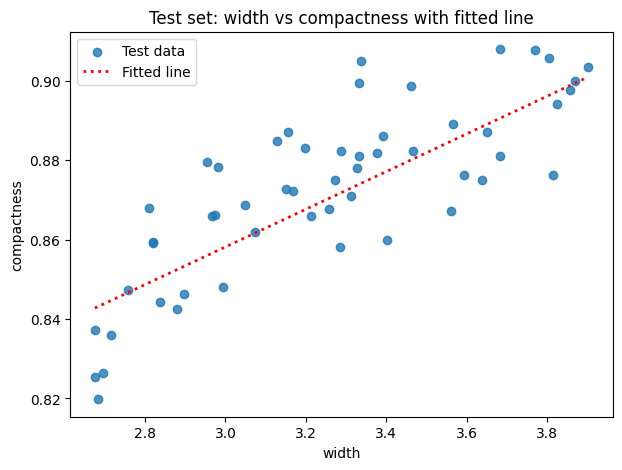

In [11]:
# Codegrade Tag Question11
# Do *not* remove the tag above
# Write your code below

import numpy as np
import matplotlib.pyplot as plt

# Assumes df_test, most_correlated_feature, and the fitted SimpleLinearRegression instance `slr` exist.

# Extract test data (feature and target)
x_test = df_test[most_correlated_feature].to_numpy(dtype=float).reshape(-1, 1)
y_test = df_test["compactness"].to_numpy(dtype=float)

# Create a range of x values for plotting the fitted line
x_line = np.linspace(x_test.min(), x_test.max(), 200).reshape(-1, 1)
y_line = slr.predict(x_line)

# Plot
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x_test.ravel(), y_test, alpha=0.8, label="Test data")
ax.plot(x_line.ravel(), y_line, linestyle=":", color="red", linewidth=2, label="Fitted line")

ax.set_xlabel(most_correlated_feature)
ax.set_ylabel("compactness")
ax.set_title(f"Test set: {most_correlated_feature} vs compactness with fitted line")
ax.legend(frameon=True)

plt.show()

## Question 12

Based on your metrics and findings above, how useful would you think the model is? Why? How could it be improved?

Another nice thing about linear regression is that it is *easy to reason* about it, it is an *explainable* model. Have a look at the coefficients of the model. How do the different things affect the decisions the model makes.

### Answer to Question 12
Write shortly, maybe 2-3 paragraphs.

The simple linear regression model is moderately useful for this dataset. Its effectiveness depends on the metrics achieved—such as R^2, RMS, MAE, and MAPE—which indicate how well it predicts compactness from a single feature. If R^2 is high and errors are low, the model captures much of the variability; if not, it mainly provides a baseline or directional guidance. RMS and MAE translate errors into the original compactness units, while MAPE offers an intuitive fractional error, though it can be unstable near zero. Overall, as a single-feature model, it provides a straightforward, interpretable approximation but leaves substantial structure unexplained.

The model could be improved by incorporating additional features in a multivariate linear regression, allowing it to capture more relationships in the data. Polynomial or interaction terms may help if residuals show curvature, and robust regression or outlier filtering can mitigate the influence of extreme points. Standard practices include checking residuals for heteroscedasticity, applying feature/target transformations when appropriate, and comparing against non-linear models to see if linearity limits performance. Its main advantage is explainability: the slope shows how the prediction changes per unit of the feature, the intercept provides a baseline, and in a multivariate extension, each coefficient reflects the ceteris paribus effect of that feature. This transparency makes it easy to interpret which factors drive compactness and by how much.